# Croptype mapping using LightGBM and Land Classification

This notebook is created as final course submission for the Data Cube course of the EAGLE master program at JMU. \
Sentinel-2 Data from the SALDi Cube is used to perform a Crop Type Classification in a part of southern Africa

Input data: 
- Sentinel-2 scenes of the months Mai - Oktober in the year 2017
- Radiant MLHub Crop Type Classification from 2017 as training input: https://mlhub.earth/data/ref_south_africa_crops_competition_v1. This data will be downloaded in prepared in the script 'training_data_processing.ipynb'.
- Digital Earth Africa Crop Map for crop masking
           
Methods:
- Calculation of several Vegetation Indices
- Usage of the LightGBM classifier

Output:
- A trained lightgbm classifier including Confusion Matrix
- A crop type classification for an area of interest in the year 2017.
           
Authors: Hyeonmin Kang and Jana Maier \
Contact: hyeonmin.kang@stud-mail.uni-wuerzburg.de; jana.maier@stud-mail.uni-wuerzburg.de \
March 2022

## 1. Load packages

In [9]:
%matplotlib inline
from pystac_client import Client
from odc.stac import stac_load, configure_rio
from odc.ui import with_ui_cbk, DcViewer

import os
from os import path as op
import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import json
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import colors

import datacube
from datacube.utils.cog import write_cog
from deafrica_tools.datahandling import load_ard
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.plotting import display_map, rgb
from dea_tools.plotting import display_map
from datacube.utils.aws import configure_s3_access

import lightgbm as lgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import rasterio
import rasterstats
from rasterio.features import rasterize
from rasterstats.io import bounds_window
from rioxarray.merge import merge_arrays
from rasterio.plot import show

## 2. Load training data 
The training data from Radiant MLHub was downloaded and preprocessed in the script 'training_data_processing.ipynb'. We stored it as a global variable and will now load it with the `%store` expression. As it were single arrays we will now merge all of them.

In [2]:
%store -r training_tifs 
merged = merge_arrays(training_tifs)

Prepare your area of interest by extracting bbox from the training data. With this bbox, we will display our area of interest on the map later. 

In [3]:
reprj_to_get_bbox = merged.rio.reproject("EPSG:4326")
training_bbox = reprj_to_get_bbox.rio.bounds()
minx, miny, maxx, maxy = training_bbox
bbox = [minx, miny, maxx, maxy]

In [4]:
bbox 

[18.873322224141276,
 -33.69457697636996,
 19.09924602035245,
 -33.460210151692124]

### View the selected location

The next cell will display the selected area on an interactive map.

In [5]:
display_map([minx, maxx], 
            [maxy, miny], crs = 'EPSG:4326')

## 3. Connect to the datacube

### List products

We are connecting to the saldi datacube, which provides us access to all data stored there. With the following cell we can get and overview about the currently available products within the datacube.

In [7]:
dc = datacube.Datacube(app = 'saldi_datacube') #datacube connection
dc.list_products()

,name,description,license,default_crs,default_resolution
name,,,,,
dem_cop_30,dem_cop_30,Copernicus DEM 30 m,None,EPSG:4326,"(-0.0002777777777777778, 0.0002777777777777778)"
esa_worldcover,esa_worldcover,"ESA World Cover, global 10 m land use/land cov...",None,EPSG:4326,"(-8.333333333333333e-05, 8.333333333333333e-05)"
s1_coherence_vv_asc,s1_coherence_vv_asc,Sentinel-1 Coherence Product (ascending),None,None,None
s1_rtc,s1_rtc,Sentinel 1 Gamma0 normalised radar backscatter,CC-BY-4.0,EPSG:4326,"(-0.0002, 0.0002)"
s2_indices,s2_indices,Indices derived from Sentinel-2 data,None,None,None
s2_l2a,s2_l2a,"Sentinel-2a and Sentinel-2b imagery, processed...",None,None,None


### Visualising available data

In [8]:
dcv = DcViewer(dc, time='2017-04-01', center=(-34,22), zoom=8)
dcv

### Load Sentinel-2 data from Datacube

Here, we load Sentinel-2 data for the specified area of interest and time range. The load_ard function is used to load data that has been masked for cloud, shadow and quality filters, making it ready for analysis.

In [9]:
# Define area of interest
lon_range = (minx, maxx)
lat_range = (maxy, miny)

# Set the range of dates for the analysis
time = ('2017-04-01', '2017-11-30')

# Set the bands that should be loaded
bands = ['red', 'green', 'blue', 'nir']

# Create a query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time,
    'measurements': bands,
    'resolution': (-10, 10),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
ds = load_ard(
    dc=dc,
    products=['s2_l2a'],
    mask_filters=[('opening', 3),('dilation', 3)],
    **query,
)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 3)]
Applying pixel quality/cloud mask
Loading 38 time steps


### Plot Sentinel-2 data
Let's plot some of the Sentinel-2 images, to see the crop variations over time.

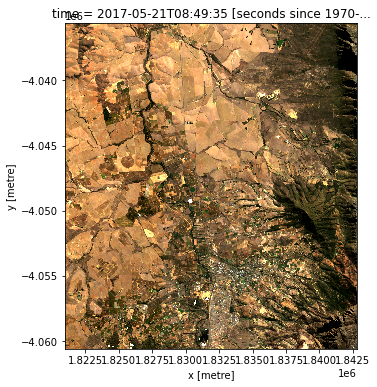

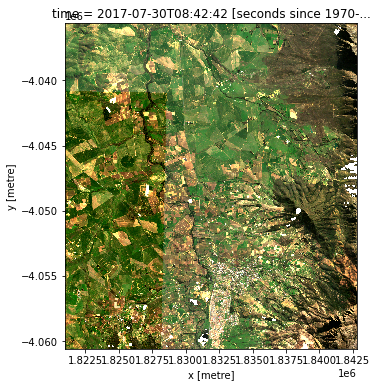

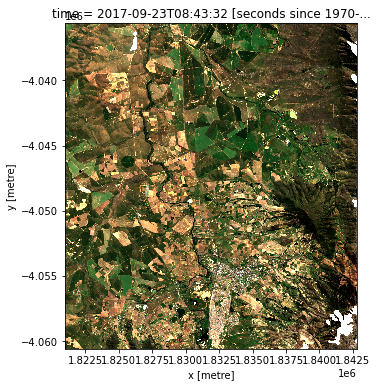

In [9]:
rgb(ds.isel(time=5), bands = ['red', 'green', 'blue'])

rgb(ds.isel(time=15), bands = ['red', 'green', 'blue'])

rgb(ds.isel(time=24), bands = ['red', 'green', 'blue'])

## 4. Mask region with DE Africa’s cropland extent map
We will use the Digital Earth Africa's crop type extent map to mask out non-crop areas.
To use this dataset we will connect to Digital Earth Africa STAC.

### Set AWS Configuration
Digital Earth Africa data is stored on S3 in Cape Town, Africa. To load the data, we must configure rasterio with the appropriate AWS S3 endpoint. This can be done with the `odc.stac.configure_rio` function.

In [10]:
configure_s3_access(aws_unsigned=True, cloud_defaults=True)

configure_rio(
    cloud_defaults=True,
    aws={"aws_unsigned": True},
    AWS_S3_ENDPOINT="s3.af-south-1.amazonaws.com",
)

### Connect to the Digital Earth Africa STAC Catalog and set Collection Configuration

In [11]:
# Open the stac catalogue
catalog = Client.open("https://explorer.digitalearth.africa/stac")

config_crop_mask_south = {
    "crop_mask_southern": {
        "assets": {
            "*": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
            "SCL": {
                "data_type": "uint8",
                "nodata": 0,
                "unit": "1",
            },
        },
        "aliases": {
            "crop_mask": "mask",
            "crop_prob": "prob",
            "mode": "filtered",
        },
    }
}

### Find STAC Items to Load

We define query parameters, construct query and get items from catalog.

In [12]:
# Set the STAC collections
collections_cm = ["crop_mask_southern"]

# Set parameters
cm_bbox = [18.40, -33.69457697636996, 19.09924602035245, -32.97]
start_date = "2018-04-01"
end_date = "2020-11-30"
crs = "EPSG:6933"
resolution = 10

# Build a query with the set parameters
query_cm = catalog.search(
    bbox=cm_bbox, collections=collections_cm, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items_cm = list(query_cm.get_items())
print(f"Found: {len(items_cm):d} datasets")


Found: 4 datasets


### Load the Data

Load the cropland mask over the region of interest. The data will be lazy-loaded with dask, meaning that is won’t be loaded into memory until necessary, such as when it is displayed.

In [13]:
cm = stac_load(
    items_cm,
    bands=("mode"),
    time=('2019'),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config_crop_mask_south,
    bbox=bbox,
    resampling='nearest', 
).mode.squeeze()

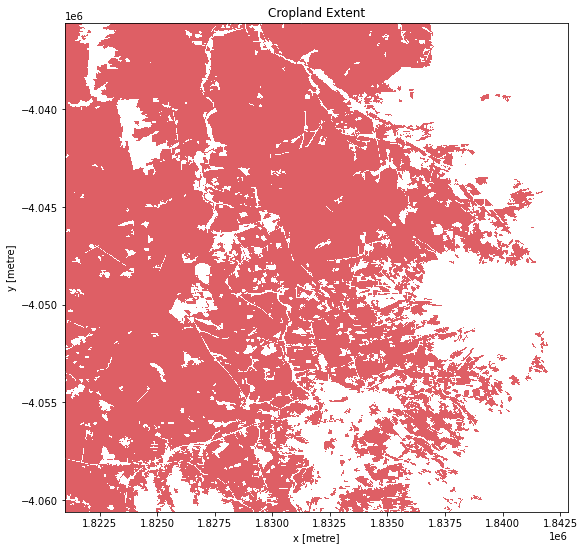

In [14]:
cm_colors = ['#ffffff',
             '#de5f65']
clr_cm = colors.ListedColormap([colors.hex2color(x) for x in cm_colors])
cm.plot.imshow(add_colorbar=False, figsize=(9,9), cmap=clr_cm)
plt.title('Cropland Extent');

Now we will use the cropland map to mask out the regions with no crop in the Sentinel-2 data.

In [15]:
ds_masked = ds.where(cm) 
ds_masked

<xarray.Dataset>
Dimensions:      (time: 38, y: 2502, x: 2181)
Coordinates:
  * time         (time) datetime64[ns] 2017-04-01T08:49:07 ... 2017-11-27T08:...
  * y            (y) float64 -4.036e+06 -4.036e+06 ... -4.061e+06 -4.061e+06
  * x            (x) float64 1.821e+06 1.821e+06 ... 1.843e+06 1.843e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) float32 dask.array<chunksize=(38, 2502, 2181), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(38, 2502, 2181), meta=np.ndarray>
    blue         (time, y, x) float32 dask.array<chunksize=(38, 2502, 2181), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(38, 2502, 2181), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

## 5. Process and explore training data

Reproject the training data to match the resolution, projection and region of the masked sentinel-2 data. This is necessary to make sure we are collection correct training data. 

In [16]:
reprojected_training_data_match = merged.rio.reproject_match(ds_masked)
reprojected_training_data_match = reprojected_training_data_match.squeeze("band")

To check the class values and the amount of pixels per class, this returns the sorted unique elements of training data labels and shows the distribution. 

In [17]:
np.array(np.unique(reprojected_training_data_match.values, return_counts=True)).T

array([[      0, 3618614],
       [      1,  128445],
       [      2,  336635],
       [      3,   49595],
       [      4,  495129],
       [      5,   15183],
       [      6,  175921],
       [      7,  515186],
       [      8,  122154]])

Additionally to the crop masking, we mask out pixels where the training data has class 0, which represents 'no data' according to the Radiant MLHub Documentation. We, therefore, use the training data to mask the Sentinel-2 data again. 

In [18]:
ds_masked_reproj = ds_masked.where(reprojected_training_data_match > 0) 

To keep the processing time low but still achieve good results, we are using 6 of the given timesteps, distributed over the year, to represent the different growing stages of the different crops.

In [19]:
final = ds_masked_reproj.isel(time=[5,8,15,18,24,31])
final

<xarray.Dataset>
Dimensions:  (time: 6, y: 2502, x: 2181)
Coordinates:
  * time     (time) datetime64[ns] 2017-05-21T08:49:35 ... 2017-10-28T08:44:12
  * y        (y) float64 -4.036e+06 -4.036e+06 ... -4.061e+06 -4.061e+06
  * x        (x) float64 1.821e+06 1.821e+06 1.821e+06 ... 1.843e+06 1.843e+06
    band     int64 1
Data variables:
    red      (time, y, x) float32 dask.array<chunksize=(6, 2502, 2181), meta=np.ndarray>
    green    (time, y, x) float32 dask.array<chunksize=(6, 2502, 2181), meta=np.ndarray>
    blue     (time, y, x) float32 dask.array<chunksize=(6, 2502, 2181), meta=np.ndarray>
    nir      (time, y, x) float32 dask.array<chunksize=(6, 2502, 2181), meta=np.ndarray>
Attributes:
    crs:           epsg:6933
    grid_mapping:  spatial_ref

These are the timesteps we chose, well distributed over the summer months.

In [20]:
final.time

<xarray.DataArray 'time' (time: 6)>
array(['2017-05-21T08:49:35.000000000', '2017-06-20T08:42:00.000000000',
       '2017-07-30T08:42:42.000000000', '2017-08-14T08:42:41.000000000',
       '2017-09-23T08:43:32.000000000', '2017-10-28T08:44:12.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-05-21T08:49:35 ... 2017-10-28T08:44:12
    band     int64 1
Attributes:
    units:    seconds since 1970-01-01 00:00:00

Now, we calculate different Vegetation Indices for our analysis. We will not use the raw band values anymore, as the indices represent their data. The SALDi Datacube contains precalculated datasets of Sentinel-2 indices, but for demonstration and training, we use the `calculate_indices` function to retrieve them.

In [21]:
final_indices = calculate_indices(final, index=['NDVI','NDWI','EVI','SAVI','MSAVI'], collection='s2')
final_indices = final_indices[['NDVI','NDWI','EVI','SAVI','MSAVI']]
final_indices_list = [final_indices.NDVI, 
                      final_indices.NDWI, 
                      final_indices.EVI,
                      final_indices.SAVI,
                      final_indices.MSAVI]

These are the classes according to Radiant MLHub, which we store in a dictionary for later use and in a list for displaying in the confusion matrix.

In [20]:
class_dict = {1: "Lucerne/Medics", 
              2: "Planted pastures (perennial)", 
              3: "Fallow", 
              4: "Wine grapes", 
              5: "Weeds", 
              6: "Small grain grazing", 
              7: "Wheat", 
              8: "Canola"}

# create a list for the confusion matrix
classes = np.fromiter(class_dict.values(), dtype='<U28')

### Plot the data
Let's have a look on the masked data of indices and the training data, showing the classified image.

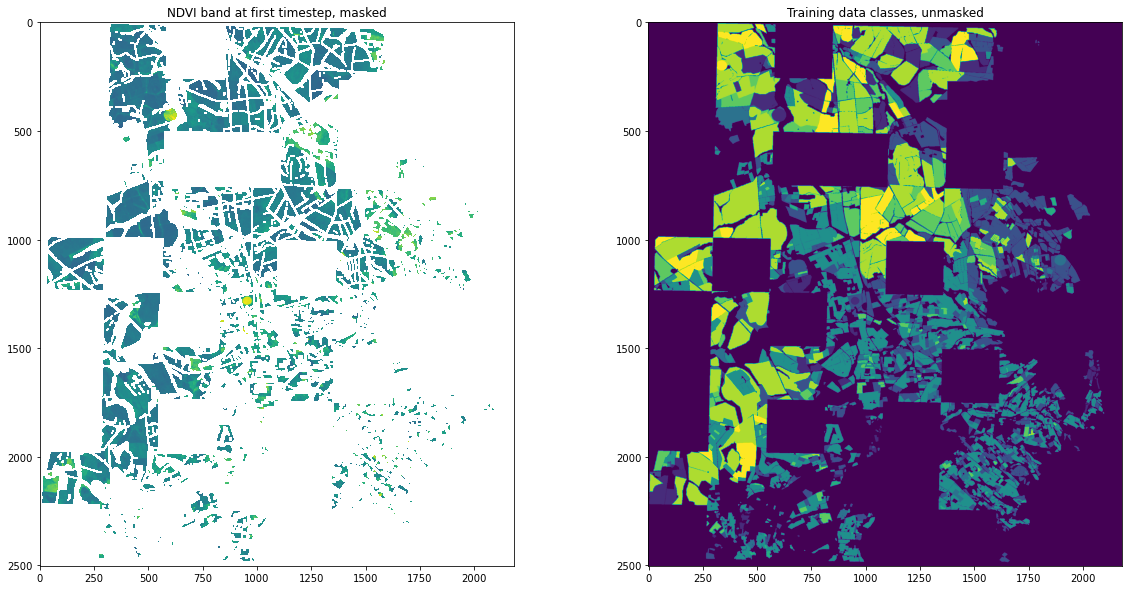

In [23]:
plt.figure(figsize = (20,10))
plt.subplot(121)
plt.imshow(final_indices.NDVI.isel(time=1))
plt.title('NDVI band at first timestep, masked')

plt.subplot(122)
plt.imshow(reprojected_training_data_match)
plt.title('Training data classes, unmasked')

plt.show()

## 6. Model Training 

We will use LightGBM Classifier, a high-performance gradient boosting framework based on decision tree algorithms.

### Preparing data for modelling 

First, we need to do some preparation to organize and reshape the training data to fit for the classifier, and to extract sample pixels from intersecting imagery. We loop through the classes and the indices, remove pixels with nan values and store the cleaned information in two lists. The resulting lists contain values of the indices (X_raw) and the matching information about the cells class (y_raw).

In [24]:
%%time
X_raw = []
y_raw = []
for croptype in range(1,len(class_dict)+1):
    index_temp_list = []
    for ind in final_indices_list: 
        class_s2 = ind.where(reprojected_training_data_match == croptype)
        class_s2_reshaped = class_s2.values.transpose(1,2,0).reshape(-1,class_s2.shape[0]) 
        class_s2_reshaped_no_nan = class_s2_reshaped[~np.isnan(class_s2_reshaped).any(axis=1)]
        index_temp_list.append(class_s2_reshaped_no_nan)
        
    class_s2_index = np.concatenate(index_temp_list, axis=1)
    rows = class_s2_index.shape[0]
    for i in range(rows):
        # add a pixel of data to X
        X_raw.append(class_s2_index[i])
        # add the class label to y
        y_raw.append(croptype)


CPU times: user 1min 32s, sys: 1min 13s, total: 2min 46s
Wall time: 2min 24s


Now we put the data into numpy arrays to be used as input for the classifier. Each row cell represents data, repeated over 6 timesteps of 5 indices (columns). The shape property shows us the dimensions of the stored data. 

In [25]:
%%time
X = np.array(X_raw)
y = np.array(y_raw)
(X.shape, y.shape)

CPU times: user 587 ms, sys: 140 ms, total: 727 ms
Wall time: 722 ms


((1580745, 30), (1580745,))

Now we split the data into test and train sets, to be able to do an accuracy assessment with the test data. We choose to have 80% as training data by putting it in the `test_size` property.

In [26]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

CPU times: user 248 ms, sys: 88.3 ms, total: 336 ms
Wall time: 332 ms


Since we don't have the same amount of training data for each class, we calculate class weights from the relative quantities. This will be used as input for the model to reduce bias.

In [27]:
%%time
labels, counts = np.unique(y_train, return_counts=True)
class_weight_dict = dict(zip(labels, 1 / counts))
class_weight_dict

CPU times: user 34.8 ms, sys: 1.11 ms, total: 35.9 ms
Wall time: 32.5 ms


{1: 1.0543407207473167e-05,
 2: 5.087996906497881e-06,
 3: 3.6138918000795055e-05,
 4: 3.1403090064062303e-06,
 5: 0.0001313197636244255,
 6: 7.5894415688893614e-06,
 7: 2.538264334847831e-06,
 8: 1.0666552890102505e-05}

### Train LightGBM

Initialize a lightgbm model with the class weights.

In [28]:
%%time
lgbm = lgb.LGBMClassifier(
       objective='multiclass',
       class_weight = class_weight_dict,
       num_class = len(class_dict),
       metric = 'multi_logloss')

CPU times: user 0 ns, sys: 52 µs, total: 52 µs
Wall time: 57.7 µs


Fit the model to the training data of values X_train and classes y_train.

In [29]:
%%time
lgbm.fit(X_train, y_train)

CPU times: user 3h 43min 50s, sys: 1min 8s, total: 3h 44min 59s
Wall time: 7min 16s


LGBMClassifier(class_weight={1: 1.0543407207473167e-05,
                             2: 5.087996906497881e-06,
                             3: 3.6138918000795055e-05,
                             4: 3.1403090064062303e-06,
                             5: 0.0001313197636244255,
                             6: 7.5894415688893614e-06,
                             7: 2.538264334847831e-06,
                             8: 1.0666552890102505e-05},
               metric='multi_logloss', num_class=8, objective='multiclass')

Predict X_test with the trained model to evaluate the model.

In [30]:
%%time
preds = lgbm.predict(X_test)
c_matrix = confusion_matrix(y_test, preds, labels=labels)
accuracy_score = accuracy_score(y_test, preds)

CPU times: user 37.3 s, sys: 27.2 ms, total: 37.3 s
Wall time: 1.45 s


Store c_matrix, and save the model for later reuse, without having to rerun the model.

In [31]:
%store c_matrix

Stored 'c_matrix' (ndarray)


In [32]:
%%time
model_name = 'light_gbm_5_index.sav'
pickle.dump(lgbm, open(op.join(model_name), 'wb'))

CPU times: user 976 ms, sys: 16.6 ms, total: 992 ms
Wall time: 136 ms


To reuse the model the following cell can be uncommented.

In [33]:
# model_name = 'light_gbm_5_index.sav'
# lgbm = pickle.load(open(op.join(model_name), 'rb'))
# lgbm

## 7. Confusion Matrix for LightGBM

In [18]:
#%store -r c_matrix

CPU times: user 148 ms, sys: 15.8 ms, total: 164 ms
Wall time: 139 ms


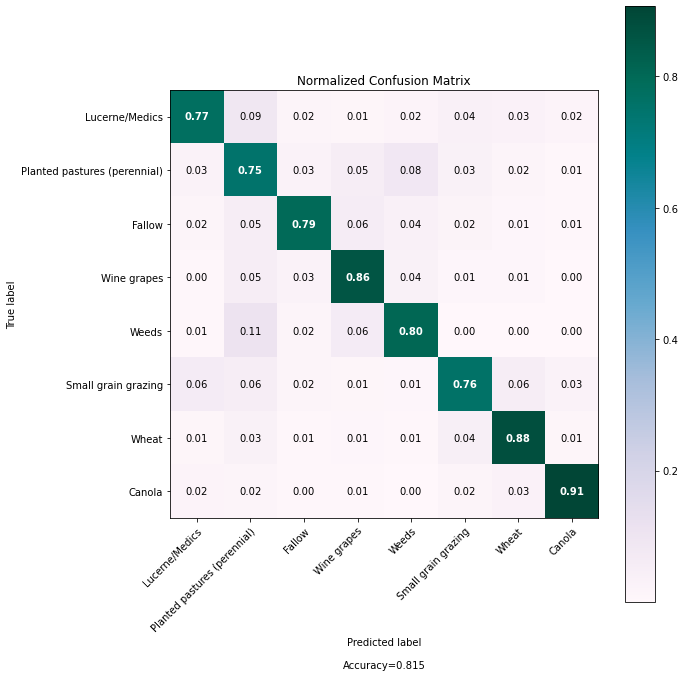

In [21]:
%%time

%matplotlib inline

c_matrix = c_matrix.astype('float') / c_matrix.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(c_matrix, interpolation='nearest', cmap=plt.cm.PuBuGn)#PuBuGn
ax.figure.colorbar(im, ax=ax)
accuracy  = np.trace(c_matrix) / float(np.sum(c_matrix))
stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
ax.set(xticks=np.arange(c_matrix.shape[1]),
       yticks=np.arange(c_matrix.shape[0]),
       # ... and label them with the respective list entries
       xticklabels=classes, yticklabels=classes,
       title='Normalized Confusion Matrix',
       ylabel='True label',
       xlabel='Predicted label' + stats_text)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
fmt = '.2f'
thresh = c_matrix.max() / 2.
for i in range(c_matrix.shape[0]):
    for j in range(c_matrix.shape[1]):
        ax.text(j, i, format(c_matrix[i, j], fmt),
                ha="center", va="center",
                weight='bold' if c_matrix[i, j] > thresh else "normal",
                color="white" if c_matrix[i, j] > thresh else "black")
fig.tight_layout()

## 8. Generate predictions over another area

### Loading the pretrained model

In [36]:
model_name = 'light_gbm_5_index.sav'
lgbm = pickle.load(open(op.join(model_name), 'rb'))

### Preparing a new image

We will now use our model to predict crop types over another area. We will repeat the data loading, crop masking with DEAfrica crop data, index calculation and data reshaping.

In [6]:
display_map([18.40, 18.70], 
            [-32.97, -33.44], crs = 'EPSG:4326')

In [22]:
classification_bbox = [18.40, -33.44, 18.70, -32.97]
lon_range = (18.40, 18.70)
lat_range = (-32.97, -33.44)

# Set the range of dates for the analysis
time = ('2017-04-01', '2017-11-30')

# Create a query
query = {
    'y': lat_range,
    'x': lon_range,
    'time': time,
    'measurements': ['red', 'green', 'blue', 'nir'],
    'resolution': (-10, 10),
    'output_crs': 'epsg:6933',
    'group_by':'solar_day'
}

# Load available data from Sentinel-2
new_ds = load_ard(
    dc=dc,
    products=['s2_l2a'],
    mask_filters=[('opening', 3),('dilation', 3)],
    **query,
)

# Select timesteps
new_ds_time = new_ds.sel(time = ['2017-05-21T08:46:35.000000000', 
                            '2017-06-20T08:42:00.000000000', 
                            '2017-07-30T08:42:42.000000000',
                            '2017-08-14T08:42:41.000000000',
                            '2017-09-23T08:43:32.000000000',
                            '2017-10-28T08:44:12.000000000'
                           ])

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying morphological filters to pq mask [('opening', 3), ('dilation', 3)]
Applying pixel quality/cloud mask
Loading 76 time steps


### Plot Sentinel-2 images of the new area

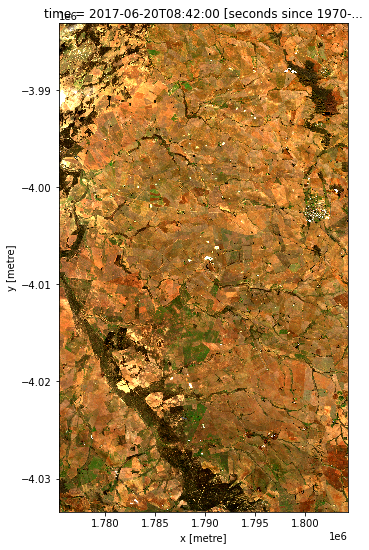

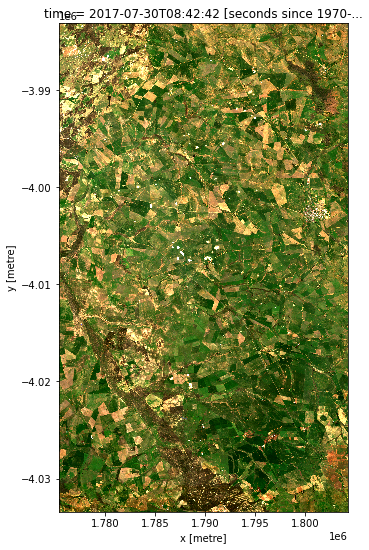

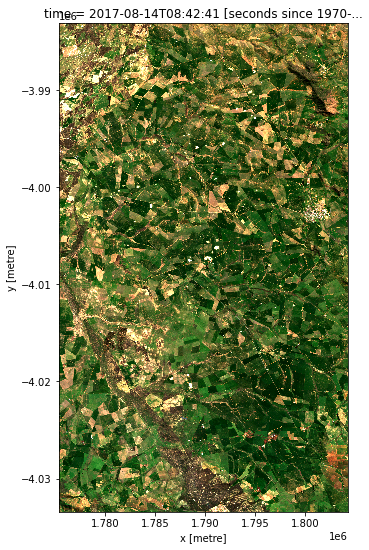

In [23]:
rgb(new_ds_time, index=[1],size=9) #June
rgb(new_ds_time, index=[2],size=9) #July
rgb(new_ds_time, index=[3],size=9) #August

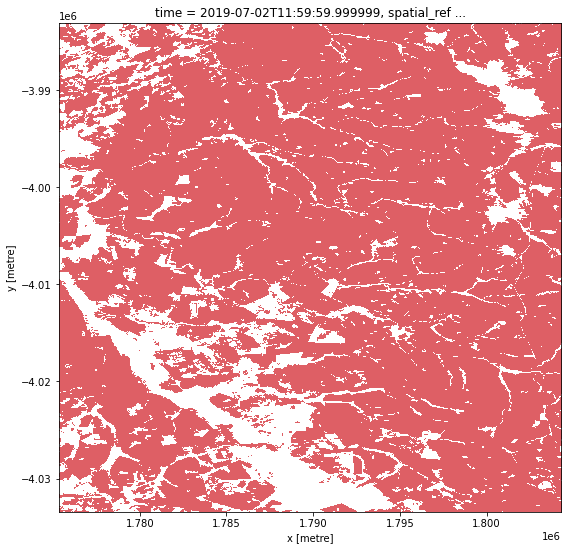

In [24]:
query_cm_new = catalog.search(
    bbox=classification_bbox, collections=collections_cm, datetime=f"{start_date}/{end_date}"
)

# Search the STAC catalog for all items matching the query
items_cm_new = list(query_cm_new.get_items())

new_cm = stac_load(
    items_cm_new,
    bands=("mode"),
    time=('2019'),
    crs=crs,
    resolution=resolution,
    chunks={},
    groupby="solar_day",
    stac_cfg=config_crop_mask_south,
    bbox=classification_bbox,
    resampling='nearest', 
).mode.squeeze()
new_cm.plot.imshow(add_colorbar=False, figsize=(9,9), cmap=clr_cm)
new_ds_masked = new_ds_time.where(new_cm) 


In [28]:
new_final_indices = calculate_indices(new_ds_masked, index=['NDVI','NDWI','EVI','SAVI','MSAVI'], collection='s2')
new_final_indices = new_final_indices[['NDVI','NDWI','EVI','SAVI','MSAVI']]
new_final_indices_list = [new_final_indices.NDVI, 
                          new_final_indices.NDWI, 
                          new_final_indices.EVI, 
                          new_final_indices.SAVI, 
                          new_final_indices.MSAVI]

We export a new image as GeoTIFF files, because we will later use a rasterio function, that needs tiff files. We can't export all 6 timesteps with 5 bands (vegetation indices) at once as one file, thus we have to download them seperately and then combine them. It is annoying but we can go through! Come on, Let's start!

In [39]:
%%time 
new_final_tif_name_list = []

for i in range(len(new_final_indices.time)):
    date = new_final_indices.isel(time=i).time.dt.strftime('%Y-%m-%d').data

    print(f'Writing {date}')
    new_file_name=f'new_final_{date}.tif'
    new_final_tif_name_list.append(new_file_name)
    new_final_img = new_final_indices.isel(time=i).to_array()

    write_geotiff_new = write_cog(geo_im=new_final_img,
              fname=f'new_final_{date}.tif',
              overwrite=True)
    write_geotiff_new.compute()

Writing 2017-05-21
Writing 2017-06-20
Writing 2017-07-30
Writing 2017-08-14
Writing 2017-09-23
Writing 2017-10-28


In [40]:
%%time 
# Read metadata of first file
with rasterio.open(new_final_tif_name_list[0]) as src0:
    stack_profile = src0.profile

# Update meta to reflect the number of layers
stack_profile.update(count = len(new_final_tif_name_list))
               
new_final_tif_file_list = []
new_final_tif_file_ndvi = []
new_final_tif_file_ndwi = []
new_final_tif_file_evi = []
new_final_tif_file_savi = []
new_final_tif_file_msavi = []

for name in new_final_tif_name_list:
    with rasterio.open(name, 'r') as f:
        new_final_tif_file_ndvi.append(f.read(1))
        new_final_tif_file_ndwi.append(f.read(2))
        new_final_tif_file_evi.append(f.read(3))
        new_final_tif_file_savi.append(f.read(4))
        new_final_tif_file_msavi.append(f.read(5))
        
joined_list = [*new_final_tif_file_ndvi, 
               *new_final_tif_file_ndwi, 
               *new_final_tif_file_evi, 
               *new_final_tif_file_savi, 
               *new_final_tif_file_msavi]  

In [41]:
%%time 
stack_profile.update(count = len(joined_list))        
with rasterio.open('stack_all_new_final_1.tif', 'w', **stack_profile) as dst:
        for id, layer in enumerate(joined_list, start=1):
                dst.write_band(id, layer)

Yuhu! we just finished stacking all the geo tiff files. Great job! We can now use the trained LightGBM classifier lgbm over a new whole satellite image covering a larger geospatial location. We split the tiff file into small tiles using rasterio window to optimize the computing power and potentially do classification in parallel.

In [42]:
%%time
patch_size = 500

with rasterio.open('stack_all_new_final_1.tif', 'r') as src:
    output_profile = src.profile
    output_profile.update(
      dtype=rasterio.uint8,
      count=1,
    )
    with rasterio.open("lgbm_classification_new_final_1.tif", 'w', **output_profile) as dst:
        # perform prediction on each small image patch to minimize required memory
        for i in range((src.shape[0] // patch_size) + 1):
            for j in range((src.shape[1] // patch_size) + 1):
                # define the pixels to read (and write)
                window = rasterio.windows.Window(
                    j * patch_size,
                    i * patch_size,
                    # don't read past the image bounds
                    min(patch_size, src.shape[1] - j * patch_size),
                    min(patch_size, src.shape[0] - i * patch_size)
                )
                data = src.read(window=window)
                img_swp = np.moveaxis(data, 0, 2)
                img_flat = img_swp.reshape(-1, img_swp.shape[-1])

                # m = np.ma.masked_invalid(img_flat)
                mask_row = np.isnan(img_flat).any(axis=1)
                to_predict = img_flat[~mask_row, :]
                if not len(to_predict):
                    continue
                img_preds = lgbm.predict(to_predict)

                # add the prediction back to the valid pixels (using only the first band of the mask to decide on validity)
                # resize to the original image dimensions
                output = np.zeros(img_flat.shape[0])
                output[~mask_row] = img_preds.flatten()
                output = output.reshape(*img_swp.shape[:-1])

                # create our final mask
                mask = (~mask_row).reshape(*img_swp.shape[:-1])

                # write to the final file
                dst.write(output.astype(rasterio.uint8), 1, window=window)
                dst.write_mask(mask, window=window)


range(0, 6)
range(0, 5)


## 9. Explore the Results 

Finally, we can explore our results. 

<AxesSubplot:title={'center':'lgbm Classes'}>

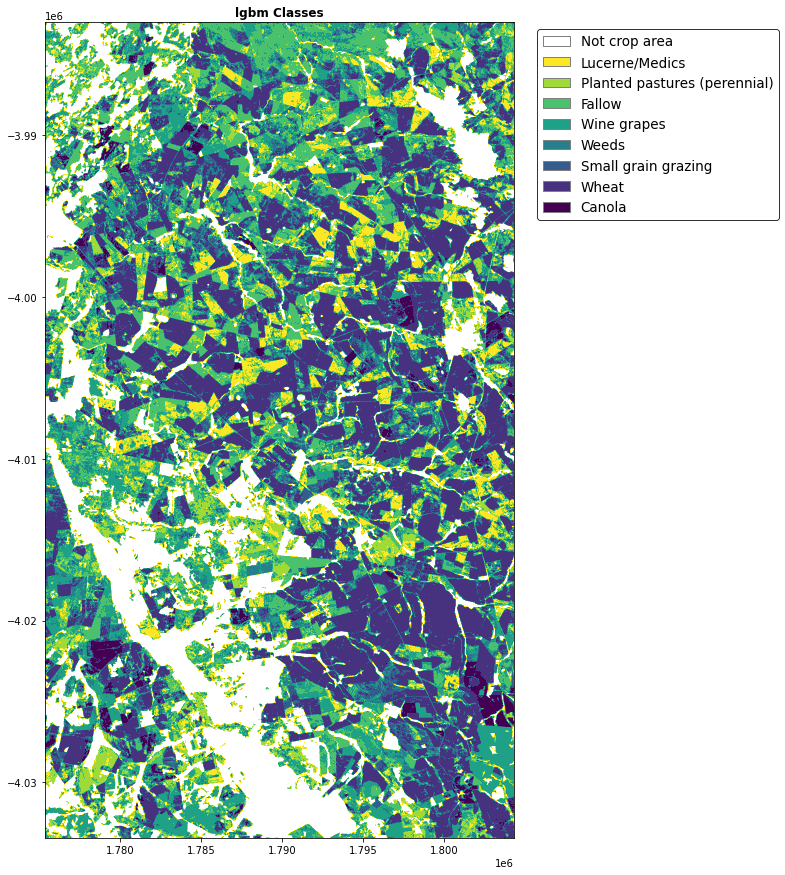

In [13]:
from matplotlib.patches import Patch
output_image = op.join("lgbm_classification_new_final_1.tif")
legend_labels = {"#ffffff": "Not crop area",
                 "#fde725": "Lucerne/Medics", 
                 "#a0da39": "Planted pastures (perennial)", 
                 "#4ac16d": "Fallow", 
                 "#1fa187": "Wine grapes", 
                 "#277f8e": "Weeds", 
                 "#365c8d": "Small grain grazing", 
                 "#46327e": "Wheat", 
                 "#440154": "Canola"}


cls_colors = list(legend_labels.keys())
clr_land = colors.ListedColormap([colors.hex2color(x) for x in cls_colors])


with rasterio.open(output_image, 'r') as class_raster:
    lgbm_classes = class_raster.read()
    
    

patches = [Patch(facecolor=color, edgecolor = "grey", label=label)
           for color, label in legend_labels.items()]




fig, ax = plt.subplots(figsize=(20, 15), sharey=True) 
ax.legend(handles=patches,
          bbox_to_anchor=(1.58, 1),
          facecolor="white",
          fontsize='13.5',
          edgecolor = 'black')


show(lgbm_classes, 
     transform=class_raster.transform, 
     ax=ax, 
     title="lgbm Classes",
     cmap=clr_land
     )


# WE LOVE DATACUBE